In [1]:
import os
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from scipy.optimize import root
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = "krylov_data4"
exact_file = "hubbard_exact_4.hdf5"
all_files = os.listdir(data_dir)
assert exact_file in all_files
ev_files = [f for f in all_files if "eigenvalues" in f]
print(len(ev_files))

11


In [3]:
# Get the exact energy.
f_exact = h5py.File(data_dir + "/" + exact_file, "r")
energy_exact = np.min(f_exact["energies"])
print(f"Exact energy is {energy_exact}.")
f_exact.close()

Exact energy is (-4.60281914709557+0j).


In [4]:
dfs = []
for evf in ev_files:
    fname = data_dir + "/" + evf
    # Get the number of steps.
    f = h5py.File(fname, "r")
    steps = f["steps"][()]
    f.close()
    # Get the upper bound.
    # fname2 = fname.replace("eigenvalues", "bound")
    # bound_df = pd.read_hdf(fname2)
    # Get the dataframe with energy vs. d
    df = pd.read_hdf(fname, key="eigenvalues")
    df["error"] = abs(df["energy"] - energy_exact) / abs(energy_exact)
    df["steps"] = steps
    df.set_index("d")
    # df_concat = pd.concat([df, bound_df], axis=1)
    # dfs.append(df_concat)
    dfs.append(df)
df_total = pd.concat(dfs)
print(df_total)

     d           eps    energy  num_pos     error  steps
i                                                       
0    3  1.000000e-08 -4.588337        3  0.003146     60
1    4  1.000000e-08 -4.600704        4  0.000460     60
2    5  1.000000e-08 -4.601492        5  0.000288     60
3    6  1.000000e-08 -4.602057        6  0.000166     60
4    7  1.000000e-08 -4.602226        7  0.000129     60
..  ..           ...       ...      ...       ...    ...
28  31  1.000000e-08 -4.602793       20  0.000006    200
29  32  1.000000e-08 -4.602794       21  0.000006    200
30  33  1.000000e-08 -4.602795       21  0.000005    200
31  34  1.000000e-08 -4.602795       22  0.000005    200
32  35  1.000000e-08 -4.602796       22  0.000005    200

[363 rows x 6 columns]


In [5]:
df_small = df_total[df_total["d"] >= 20]
print(df_small)

     d           eps    energy  num_pos     error  steps
i                                                       
17  20  1.000000e-08 -4.602678       15  0.000031     60
18  21  1.000000e-08 -4.602687       15  0.000029     60
19  22  1.000000e-08 -4.602693       16  0.000027     60
20  23  1.000000e-08 -4.602700       16  0.000026     60
21  24  1.000000e-08 -4.602705       17  0.000025     60
..  ..           ...       ...      ...       ...    ...
28  31  1.000000e-08 -4.602793       20  0.000006    200
29  32  1.000000e-08 -4.602794       21  0.000006    200
30  33  1.000000e-08 -4.602795       21  0.000005    200
31  34  1.000000e-08 -4.602795       22  0.000005    200
32  35  1.000000e-08 -4.602796       22  0.000005    200

[176 rows x 6 columns]


In [6]:
df_small = df_total[df_total["d"] >= 14]
print(df_small.head())

     d           eps    energy  num_pos     error  steps
i                                                       
11  14  1.000000e-08 -4.602606       12  0.000046     60
12  15  1.000000e-08 -4.602621       12  0.000043     60
13  16  1.000000e-08 -4.602637       13  0.000040     60
14  17  1.000000e-08 -4.602649       13  0.000037     60
15  18  1.000000e-08 -4.602659       14  0.000035     60


Text(0, 0.5, 'Relative error in energy')

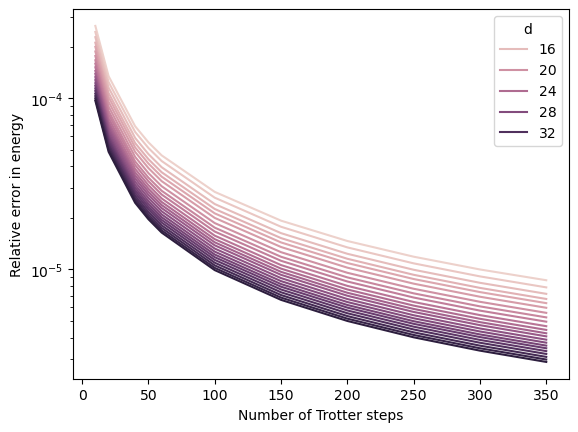

In [11]:
fig, ax = plt.subplots()
ax.set_yscale("log")
sns.lineplot(ax=ax, data=df_small, x="steps", y="error", hue="d")
ax.set_xlabel("Number of Trotter steps")
ax.set_ylabel("Relative error in energy")
# plt.savefig("hubbard_4_error.pdf")

In [8]:
def find_num_steps(steps, errors, accuracy, t0):
    """Find the number of steps for a given accuracy by interpolation."""

    assert np.min(errors) <= accuracy <= np.max(errors),\
        f"Accuracy {accuracy} must be between {np.min(errors)} and {np.max(errors)}"
    spline = CubicSpline(steps, errors)
    solution = root(lambda nt: spline(nt) - accuracy, t0)
    if not solution.success:
        print("Solver did not converge.")
    return solution.x

In [9]:
for d in range(3, 17):
    df_d = df_total[df_total["d"] == d]
    errors = df_d["error"].to_numpy()
    print(d, np.min(errors), np.max(errors))

3 0.0029165760498277744 0.0045395716058036824
4 0.00023120119583475368 0.001755546067332558
5 7.891469468999991e-05 0.0010971507234497017
6 5.006013472373426e-05 0.0007915450815409949
7 3.0842196609433724e-05 0.0006252335337036253
8 2.356574710144267e-05 0.0005265795416397288
9 1.7802929649786548e-05 0.0004502693420550746
10 1.4886665045631371e-05 0.0003970106102708502
11 1.2500940121869439e-05 0.0003515359225369781
12 1.094712343602196e-05 0.0003186026820641069
13 9.574252208038444e-06 0.0002873879567368486
14 8.649453373836067e-06 0.0002647568553298057
15 7.857460581804125e-06 0.00024417998122241714
16 7.203085262837999e-06 0.0002277383680818038


In [10]:
# For each given error, find how many steps it would take to produce, along wih the required d.
errs = [0.1, 0.1, 1e-2, 1e-2, 1e-2, 1e-3, 5e-4]
ds = [3, 4, 7, 8, 9, 14, 15]
nt0 = [50, 50, 250, 200, 200, 200, 200] # Guess at number of steps.

for err, d, nt in zip(errs, ds, nt0):
    df_d = df_total[df_total["d"] == d]
    df_d.sort_values("steps", inplace=True)
    errors = df_d["error"].to_numpy()
    steps = df_d["steps"].to_numpy()
    steps = find_num_steps(steps, errors, err, nt)
    print(err, d, steps)

/var/folders/rv/3v7hvpgn6ks14zr4w90jz4zc0000gn/T/ipykernel_2262/1125365208.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d.sort_values("steps", inplace=True)


AssertionError: Accuracy 0.1 must be between 0.0029165760498277744 and 0.0045395716058036824